In [1]:
import networkx as nx

import matplotlib.pyplot as plt
import random
import json
import community as community_louvain

import numpy as np

import numpy as np
from scipy.sparse import csr_matrix

# 设置随机种子
random.seed(42)
np.random.seed(42)
from networkx.algorithms.community import girvan_newman

In [2]:
def read_undirected_graph(file_path, skip_lines):
    G = nx.Graph()  # 初始化一个空的无向图
    with open(file_path, 'r') as file:
        for _ in range(skip_lines):
            next(file)  # 跳过文件开头的描述性行
        for line in file:
            parts = line.strip().split()
            if len(parts) >= 2:  # 确保行里至少有两个元素
                u, v = parts[0], parts[1]  # 只取第一和第二个元素
                G.add_edge(u, v)  # 在无向图中添加边
    
    return G

# 示例用法
path = '/Users/qing/Desktop/24s1/comp8880/project/code/data/soc/socfb-wosn-friends/socfb-wosn-friends.edges'
G = read_undirected_graph(path, 0)

In [3]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

num_nodes, num_edges

(63731, 817090)

In [11]:
centrality = nx.degree_centrality(G)
pagerank = nx.pagerank(G, alpha=0.85, personalization=None)
leaderRank = leader_rank(G)
hIndex = calculate_h_index(G)
kShell = nx.core_number(G)

In [12]:
sorted_centrality = sorted(centrality.items(), key=lambda item: item[1], reverse=True)

sorted_pagerank =  sorted(pagerank.items(), key=lambda item: item[1], reverse=True)
sorted_leaderRank =  sorted(leaderRank.items(), key=lambda item: item[1], reverse=True)
sorted_hIndex =  sorted(hIndex.items(), key=lambda item: item[1], reverse=True)
sorted_kShell=  sorted(kShell.items(), key=lambda item: item[1], reverse=True)


In [9]:
print(sorted_centrality[:3])

print(sorted_pagerank[:3])
print(sorted_leaderRank[:3])
print(sorted_hIndex[:3])
print(sorted_kShell[:3])

[('2332', 0.01722839389945396), ('471', 0.014623736898261469), ('554', 0.014388376325864557)]
[('554', 0.0006157378937781408), ('471', 0.0005181025397725531), ('2332', 0.0004908120233521955)]
[('2332', 0.000647257172160189), ('471', 0.0005495047623810126), ('554', 0.0005406743326444649)]
[('9904', 184), ('5170', 179), ('2362', 170)]
[('14', 52), ('1528', 52), ('451', 52)]


In [10]:

# 假设 sorted_centrality, sorted_betweenness 等都是已经计算好并排序的元组列表
data_to_save = {
    "Centrality": sorted_centrality,
    "PageRank": sorted_pagerank,
    "LeaderRank": sorted_leaderRank,
    "HIndex": sorted_hIndex,
    "KShell": sorted_kShell
}

with open('saved/network_metrics_face.json', 'w') as f:
    json.dump(data_to_save, f, indent=4)


In [5]:
partition_file = 'saved/partition_twit.json'
# 从 JSON 文件加载分区
with open(partition_file, 'r') as f:
    partition = json.load(f)

In [9]:
centrality = nx.degree_centrality(G)

In [6]:
G_edge = nx.read_edgelist('/Users/qing/Desktop/24s1/comp8880/project/code/data/soc/socfb-wosn-friends/socfb-wosn-friends.edges',data=False) 


In [7]:
partition = community_louvain.best_partition(G_edge)


In [29]:
partition_file = 'saved/partition_facebook.json'
with open(partition_file, 'w') as f:
    json.dump(partition, f)


In [8]:
def community_aware_ranking(G, partition, node_centrality, budget=None):
    # Organize nodes by community and sort them within each community based on their centrality
    community_nodes = {}
    for node, comm in partition.items():
        if comm not in community_nodes:
            community_nodes[comm] = []
        community_nodes[comm].append(node)

    for comm in community_nodes:
        community_nodes[comm].sort(key=lambda x: node_centrality[x], reverse=True)

    # Select nodes from communities ensuring distribution across communities
    ranked_nodes = []
    if budget is None:
        budget = len(G)
    
    while budget > 0 and any(community_nodes.values()):
        for comm in sorted(community_nodes, key=lambda x: len(community_nodes[x]), reverse=True):
            if community_nodes[comm]:
                ranked_nodes.append(community_nodes[comm].pop(0))
                budget -= 1
                if budget == 0:
                    break
    
    return ranked_nodes

In [9]:
def community_aware_ranking_ours_v4(partition, leader_rank_scores, community_kshell, budget=10, alpha=2.5):
    # Organize nodes by community and sort them within each community based on their centrality
    community_nodes = {}
    for node, comm in partition.items():
        if comm not in community_nodes:
            community_nodes[comm] = []
        community_nodes[comm].append(node)

    for comm in community_nodes:
        community_nodes[comm].sort(key=lambda x: leader_rank_scores[x], reverse=True)

    # Calculate total k-shell values for each community to determine budget distribution
    community_kshell_sums = {}
    for node, comm in partition.items():
        if comm not in community_kshell_sums:
            community_kshell_sums[comm] = 0
        community_kshell_sums[comm] += community_kshell[node]

    # Calculate total k-shell values across all communities to normalize the distribution
    total_kshell_sum = sum(community_kshell_sums.values())

    # Determine budget for each community based on their k-shell sum raised to the power alpha
    community_budgets = {comm: int(((community_kshell_sums[comm] / total_kshell_sum) ** alpha) * budget) for comm in community_nodes}

    # Adjust budgets due to integer rounding, distribute any remaining budget
    allocated_budget = sum(community_budgets.values())
    while allocated_budget < budget:
        for comm in sorted(community_budgets, key=lambda x: community_kshell_sums[x], reverse=True):
            community_budgets[comm] += 1
            allocated_budget += 1
            if allocated_budget == budget:
                break

    # Select nodes from communities based on assigned budgets
    ranked_nodes = []
    for comm in sorted(community_nodes, key=lambda x: community_kshell_sums[x], reverse=True):
        ranked_nodes.extend(community_nodes[comm][:community_budgets[comm]])

    return ranked_nodes


In [32]:
import infomap

In [33]:
# 创建节点映射，将节点字符串映射为整数，同时创建反向映射
node_map = {node: i for i, node in enumerate(G_edge.nodes())}
reverse_node_map = {i: node for node, i in node_map.items()}  # 反向映射

# 初始化 Infomap
im = infomap.Infomap()

# 将网络数据添加到 Infomap 对象，确保节点ID是整数
for edge in G_edge.edges():
    source, target = edge
    im.add_link(node_map[source], node_map[target])

# 运行 Infomap 算法
im.run()


. Found 4 levels with codelength 12.29357608

=> Trial 1/1 finished in 6.63488763s with codelength 12.2935761


Summary after 1 trial
Best end modular solution in 4 levels:
Per level number of modules:         [        147,        2421,         130,           0] (sum: 2698)
Per level number of leaf nodes:      [          0,         328,       62602,         804] (sum: 63734)
Per level average child degree:      [        147,     18.7007,     25.9116,     6.18462] (average: 25.6424)
Per level codelength for modules:    [0.141147229, 3.681797327, 0.007500512, 0.000000000] (sum: 3.830445067)
Per level codelength for leaf nodes: [0.000000000, 0.000306173, 8.443952205, 0.018872637] (sum: 8.463131015)
Per level codelength total:          [0.141147229, 3.682103500, 8.451452717, 0.018872637] (sum: 12.293576082)

  Infomap ends at 2024-05-17 17:10:35
  (Elapsed time: 7.34962973s)
  Infomap v2.7.1 starts at 2024-05-17 17:14:25
  -> Input network: 
  -> No file output!
  -> Ordinary network input

In [34]:

# 提取社区分区结果，直接使用反向映射
partition_infomap = {}
for node in im.tree:
    if node.is_leaf:
        original_node = reverse_node_map[node.node_id]  # 直接使用反向映射查找原始节点标识符
        partition_infomap[original_node] = node.module_id
        
        
partition_file = 'saved/partition_facebook_infomap.json'
with open(partition_file, 'w') as f:
    json.dump(partition_infomap, f)


In [16]:
import networkx as nx
import numpy as np
import community as community_louvain

def community_aware_ranking_ours_v5(G, partition, degree_centrality, k_shell_scores, total_budget, distance_threshold):
    """
    对社交网络进行资源分配和节点选择，结合社区划分、节点度中心性、k-shell得分和距离阈值。
    使用线性归一化来代替Softmax进行预算分配。

    参数:
    G: NetworkX图对象，表示社交网络。
    partition: 字典，节点到社区ID的映射。
    degree_centrality: 字典，节点的度中心性得分。
    k_shell_scores: 字典，节点的k-shell得分。
    total_budget: 整个网络的总预算，表示可以选择的节点总数。
    alpha: k-shell得分的权重。
    beta: 社区大小得分的权重。
    distance_threshold: 最短路径距离阈值，用于确定节点间的紧密程度。

    返回:
    selected_nodes: 被选择的节点集合。
    """

    communities = {}
    for node, comm_id in partition.items():
        if comm_id not in communities:
            communities[comm_id] = []
        communities[comm_id].append(node)

    community_scores = {}
    for comm_id, nodes in communities.items():
        core_score = np.mean([k_shell_scores[node] for node in nodes])  # 计算该社区的平均k-shell得分
        size_score = len(nodes)  # 获取社区的大小
        community_scores[comm_id] = size_score * (core_score)
    #print("Community Scores:", community_scores)

    # 使用线性归一化来分配预算
    total_score = sum(community_scores.values())
    community_budgets = {comm: int((score / total_score) * total_budget) for comm, score in community_scores.items()}

   # print(community_budgets)
    # 选择节点，考虑节点间的距离阈值
    selected_nodes = set()
    for comm_id in communities:
        community_nodes = communities[comm_id]
        budget = community_budgets[comm_id]
        selected_for_comm = []

        # 按度中心性排序
        nodes_sorted = sorted(community_nodes, key=lambda n: degree_centrality[n], reverse=True)

        for node in nodes_sorted:
            if len(selected_for_comm) < budget:
                # 检查距离阈值
                too_close = any(nx.has_path(G, node, selected_node) and nx.shortest_path_length(G, node, selected_node) <= distance_threshold for selected_node in selected_for_comm)
                if not too_close:
                    selected_for_comm.append(node)
                    selected_nodes.add(node)
                    
    return selected_nodes

# 注意：使用该函数前需要提供有效的G, partition, degree_centrality, k_shell_scores等数据。


In [17]:
indegree_centrality = nx.in_degree_centrality(G)

NetworkXNotImplemented: not implemented for undirected type

In [13]:
kShell = nx.core_number(G)

In [21]:
leaderRank = leader_rank(G)

In [13]:
degree_centrality = nx.degree_centrality(G)

In [14]:

budget = 200


ranked_nodes_ours = community_aware_ranking_ours_v4(partition, leaderRank,kShell, budget)
ranked_nodes_baseline = community_aware_ranking(G, partition, degree_centrality, budget)

print("Ranked Nodes:", ranked_nodes_ours)
print("Ranked informap Nodes:", ranked_nodes_baseline)


Ranked Nodes: ['2332', '2322', '2208', '9904', '3943', '2362', '471', '554', '451', '11069', '6313', '1506', '84', '2184', '5888', '22177', '14253', '22297', '12953', '5302', '4758', '585', '33698', '42467', '12597', '4015', '34985', '60508', '31832', '11051', '8009', '42088', '49083', '50035', '58788', '30118', '30561', '45959', '45813', '59790', '28835', '44163', '51425', '51123', '49774', '56114', '51818', '53503', '59230', '49119', '40269', '2729', '56948', '40732', '50994', '53368', '43819', '46212', '53546', '52300', '50337', '47685', '52649', '57102', '57934', '59466', '60083', '62297', '58909', '47426', '48368', '56612', '60108', '50553', '60203', '49538', '29972', '61254', '55361', '51524', '57517', '59141', '61214', '36869', '61263', '57819', '32787', '42840', '52354', '61241', '58470', '47051', '47622', '48982', '49268', '52667', '53950', '54139', '54883', '54960', '55357', '55408', '55521', '55687', '56246', '59296', '59884', '59925', '60945', '61446', '62354', '15606', '37

In [43]:
ranked_nodes_v5 = community_aware_ranking_ours_v5(G_edge, partition, leaderRank, hIndex, budget, distance_threshold=0)


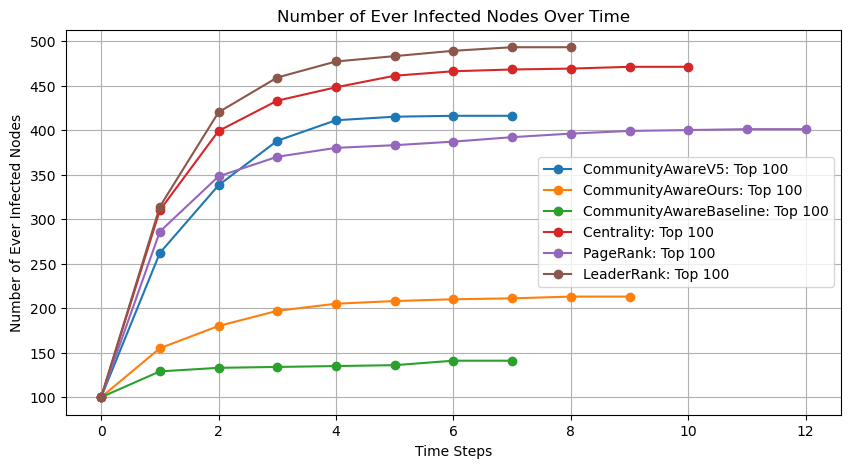

In [46]:

def plot_sir_simulation(G, sorted_maps, top, infection_prob=0.05, steps=100):
    plt.figure(figsize=(10, 5))

    # Calculate average in-degree
    #avg_in_degree = sum(dict(G.in_degree()).values()) / G.number_of_nodes()
    #print(avg_in_degree)
    #recovery_prob = 1 / avg_in_degree

    # Iterate through all sorted maps
    for name, sorted_map in sorted_maps.items():
        top_nodes = [node for node, _ in sorted_map[:top]]  # Extract top nodes
        history, ever_infected, infected_counts = SIR_simulation(G, top_nodes, infection_prob, 1, steps)
        plt.plot(infected_counts, marker='o', linestyle='-', label=f'{name}: Top {top}')

    plt.title('Number of Ever Infected Nodes Over Time')
    plt.xlabel('Time Steps')
    plt.ylabel('Number of Ever Infected Nodes')
    plt.grid(True)
    plt.legend()
    plt.show()

def SIR_simulation(G, initial_infected, infection_prob=0.1, recovery_prob=0.05, steps=100):
    # Initialize the status of each node
    status = {node: 'S' for node in G.nodes()}
    for node in initial_infected:
        status[node] = 'I'

    history = []
    ever_infected = set(initial_infected)
    infected_counts = [len(ever_infected)]  # Initial number of infected nodes

    # Simulation process
    for _ in range(steps):
        new_status = status.copy()
        for node in G.nodes():
            if status[node] == 'I':
                # Determine neighbors based on whether the graph is directed
                if G.is_directed():
                    # For directed graphs, consider nodes that have edges towards 'node'
                    neighbors = [n for n in G.predecessors(node)]
                else:
                    # For undirected graphs, consider all neighbors
                    neighbors = list(G.neighbors(node))

                # Attempt to infect neighbors
                for neighbor in neighbors:
                    if status[neighbor] == 'S' and random.random() < infection_prob:
                        new_status[neighbor] = 'I'
                        ever_infected.add(neighbor)
                # Recovery process
                if random.random() < recovery_prob:
                    new_status[node] = 'R'
        history.append(new_status)
        status = new_status
        infected_counts.append(len(ever_infected))  # Record the total number of infected nodes

        if not any(s == 'I' for s in status.values()):
            break

    return history, ever_infected, infected_counts



sorted_maps = {
    "CommunityAwareV5": [(node, degree_centrality[node]) for node in ranked_nodes_v5],
     "CommunityAwareOurs": [(node, degree_centrality[node]) for node in ranked_nodes_ours],
    # "CommunityAwareInforMap": [(node, centrality[node]) for node in ranked_nodes_ours_infomap],
    "CommunityAwareBaseline": [(node, degree_centrality[node]) for node in ranked_nodes_baseline],
    "Centrality": sorted_centrality,
    "PageRank": sorted_pagerank,
    "LeaderRank": sorted_leaderRank,
   # "H-index": sorted_hIndex,
    #"K-Shell": sorted_kShell
}


# 运行模拟并绘图
plot_sir_simulation(G, sorted_maps,top=100, infection_prob=0.005,steps=15)

In [26]:
# 使用Louvain算法进行社区检测
def detect_communities(G):
    partition = community_louvain.best_partition(G)
    return partition


# 统计前top节点在各社区中的分布
def count_top_nodes_in_communities(G, sorted_maps, top, partition):
    community_counts = {name: {} for name in sorted_maps.keys()}
    
    for name, sorted_map in sorted_maps.items():
        top_nodes = [node for node, _ in sorted_map[:top]]  # 提取前top个节点
        for node in top_nodes:
            community = partition[node]
            if community not in community_counts[name]:
                community_counts[name][community] = 0
            community_counts[name][community] += 1
    
    return community_counts

# 可视化前top节点在各社区中的分布
def plot_top_nodes_distribution(community_counts, top):
    plt.figure(figsize=(15, 10))

    for i, (name, counts) in enumerate(community_counts.items()):
        communities = list(counts.keys())
        counts = list(counts.values())
        
        plt.subplot(3, 3, i + 1)
        plt.bar(communities, counts)
        plt.title(f'Distribution of Top {top} Nodes in Communities\n({name})')
        plt.xlabel('Community')
        plt.ylabel('Number of Top Nodes')

    plt.tight_layout()
    plt.show()

# 统计每个社区的节点数量并排序
def count_and_sort_communities(partition):
    community_counts = {}
    for node, community in partition.items():
        if community not in community_counts:
            community_counts[community] = 0
        community_counts[community] += 1
    
    # 按照节点数量排序社区
    sorted_community_counts = sorted(community_counts.items(), key=lambda x: x[1], reverse=True)
    return sorted_community_counts

In [24]:
# 示例：检测社区并统计前top节点的分布
G_edge = nx.read_edgelist('/Users/qing/Desktop/24s1/comp8880/project/code/data/soc/soc-twitter-follows-mun.edges')  # 加载您的网络数据
partition = detect_communities(G_edge)



In [25]:
partition_file = 'saved/partition_twit.json'
with open(partition_file, 'w') as f:
    json.dump(partition, f)



In [ ]:
print(f"Partition saved to {partition_file}")

# 从 JSON 文件加载分区
with open(partition_file, 'r') as f:
    loaded_partition = json.load(f)

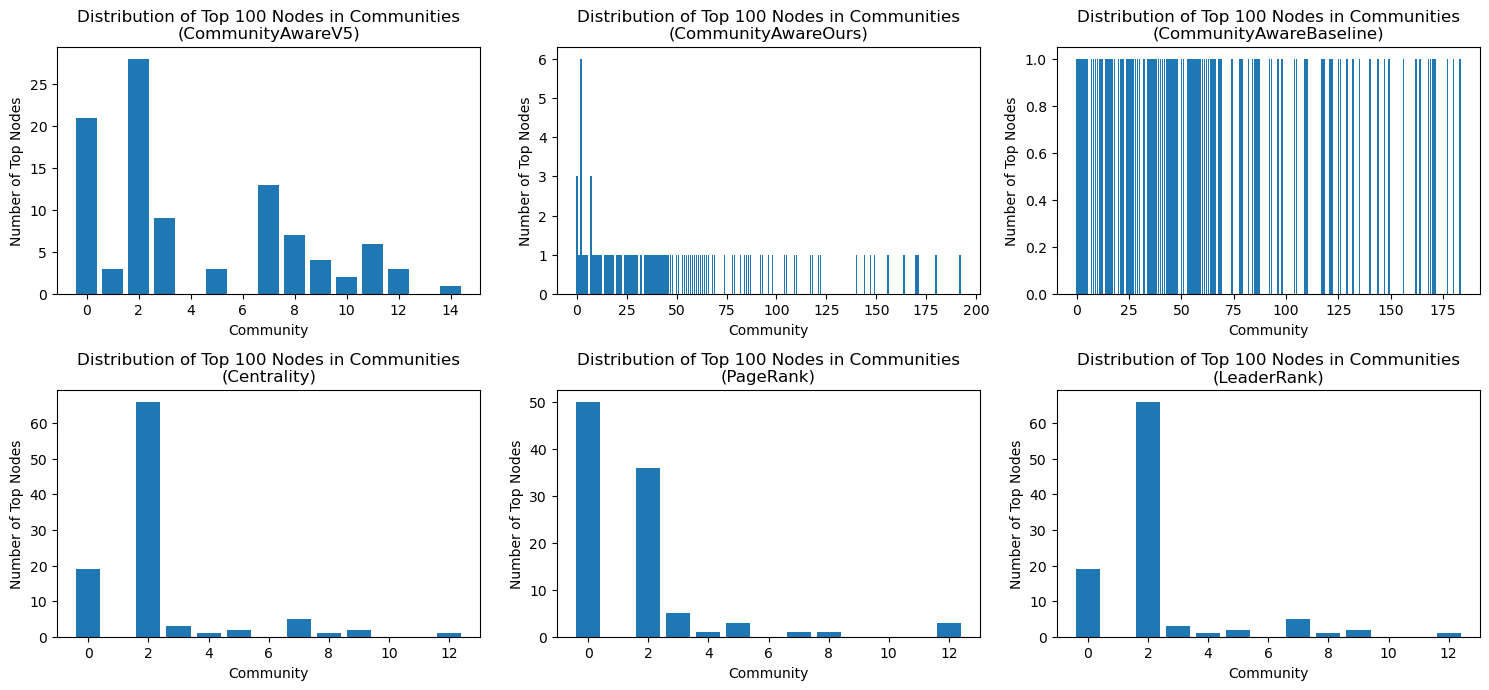

In [47]:

top = 100

community_counts = count_top_nodes_in_communities(G_edge, sorted_maps, top, partition)
plot_top_nodes_distribution(community_counts, top)

In [99]:

sorted_community_counts = count_and_sort_communities(partition)

for community, count in sorted_community_counts:
    print(f"Community {community}: {count} nodes")


Community 0: 15963 nodes
Community 2: 9697 nodes
Community 3: 8871 nodes
Community 9: 5252 nodes
Community 10: 3992 nodes
Community 4: 3956 nodes
Community 11: 3630 nodes
Community 7: 3372 nodes
Community 6: 3016 nodes
Community 1: 1845 nodes
Community 5: 1260 nodes
Community 14: 765 nodes
Community 8: 686 nodes
Community 23: 669 nodes
Community 18: 103 nodes
Community 22: 37 nodes
Community 40: 18 nodes
Community 17: 16 nodes
Community 24: 13 nodes
Community 35: 13 nodes
Community 90: 13 nodes
Community 28: 11 nodes
Community 94: 11 nodes
Community 34: 10 nodes
Community 54: 9 nodes
Community 58: 9 nodes
Community 15: 8 nodes
Community 16: 8 nodes
Community 19: 8 nodes
Community 33: 7 nodes
Community 45: 7 nodes
Community 49: 7 nodes
Community 21: 6 nodes
Community 26: 6 nodes
Community 37: 6 nodes
Community 38: 6 nodes
Community 46: 6 nodes
Community 20: 5 nodes
Community 27: 5 nodes
Community 42: 5 nodes
Community 74: 5 nodes
Community 77: 5 nodes
Community 83: 5 nodes
Community 130

In [95]:
%pip install igraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 4.9 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [102]:
import igraph as ig
def calculate_community_diameters_igraph(G, partition):
    # 初始化社区字典
    communities = {}
    for node, comm_id in partition.items():
        if comm_id not in communities:
            communities[comm_id] = []
        communities[comm_id].append(node)
    
    # 存储每个社区的直径
    diameters = {}
    for comm_id, nodes in communities.items():
        if len(nodes) >= 20:
            # 创建子图
            subgraph = G.subgraph(nodes)
            # 将 networkx 图转换为 igraph 图
            edges = [(e.source, e.target) for e in subgraph.es]
            ig_subgraph = ig.Graph(edges=edges, directed=False)
            # 计算直径
            diameter = ig_subgraph.diameter(directed=False, unconn=False)
            diameters[comm_id] = diameter
        else:
            # 对节点数少于20的社区设置直径为0
            diameters[comm_id] = 0

    return diameters


In [103]:
diameters = calculate_community_diameters(G, partition)


KeyboardInterrupt: 

In [ ]:

# 可视化直径分布
plt.hist(diameters.values(), bins=len(set(diameters.values())))
plt.title('社区直径分布')
plt.xlabel('直径')
plt.ylabel('社区数量')
plt.show()

In [10]:


def leader_rank(G2, damping=0.85, tol=1e-6, max_iter=100):
    # Add the ground node connected to all other nodes
    ground_node = 'ground'
    G = G2.copy()
    G.add_node(ground_node)
    for node in G2.nodes():  # Connect the ground node to all other nodes
        G.add_edge(ground_node, node)
        G.add_edge(node, ground_node)  # Assuming undirected graph, add both directions

    # Create a mapping from node to index
    node_list = list(G.nodes())
    node_index = {node: i for i, node in enumerate(node_list)}
    n = len(node_list)
    
    # Initialize scores to 1 for all nodes
    scores = np.ones(n)
    
    # Create adjacency matrix
    row = []
    col = []
    data = []
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        if neighbors:
            degree = len(neighbors)
            for neighbor in neighbors:
                row.append(node_index[neighbor])
                col.append(node_index[node])
                data.append(1.0 / degree)
    
    adjacency_matrix = csr_matrix((data, (row, col)), shape=(n, n))
    
    # Power iteration: iterate until convergence
    for _ in range(max_iter):
        new_scores = adjacency_matrix.dot(scores)
        if np.linalg.norm(new_scores - scores, 1) < tol:
            break
        scores = new_scores
    
    # Remove the ground node score and normalize the scores
    scores = np.delete(scores, node_index[ground_node])
    total_score = np.sum(scores)
    scores /= total_score
    
    # Create the final scores dictionary
    final_scores = {node_list[i]: scores[i] for i in range(n) if node_list[i] != ground_node}
    
    return final_scores


def calculate_h_index(G):
    h_index = {}
    for node in G.nodes():
        degrees = [G.degree(neighbor) for neighbor in G.neighbors(node)]
        degrees.sort(reverse=True)
        h = 0
        for i, degree in enumerate(degrees):
            if degree >= i + 1:
                h = i + 1
            else:
                break
        h_index[node] = h
    return h_index


In [10]:
# Initialize an empty directed graph
# Load the .mtx file
wiki_path = '/Users/qing/Desktop/24s1/comp8880/project/code/data/wiki-Vote.txt'
G_wiki = read_directed_graph(wiki_path,4)
# Calculate number of nodes and edges in the graph
num_nodes = G_wiki.number_of_nodes()
num_edges = G_wiki.number_of_edges()

num_nodes, num_edges

centrality = nx.degree_centrality(G_wiki)
betweenness_manual = nx.betweenness_centrality(G_wiki)
closeness_manual = nx.closeness_centrality(G_wiki)
pagerank = nx.pagerank(G_wiki, alpha=0.85, personalization=None)
leaderRank = leader_rank(G_wiki)
hIndex = calculate_h_index(G_wiki)
kShell = nx.core_number(G_wiki)

sorted_centrality = sorted(centrality.items(), key=lambda item: item[1], reverse=True)
sorted_betweenness = sorted(betweenness_manual.items(), key=lambda item: item[1], reverse=True)
sorted_closeness = sorted(closeness_manual.items(), key=lambda item: item[1], reverse=True)
sorted_pagerank =  sorted(pagerank.items(), key=lambda item: item[1], reverse=True)
sorted_leaderRank =  sorted(leaderRank.items(), key=lambda item: item[1], reverse=True)
sorted_hIndex =  sorted(hIndex.items(), key=lambda item: item[1], reverse=True)
sorted_kShell=  sorted(kShell.items(), key=lambda item: item[1], reverse=True)


print(sorted_centrality[:3])
print(sorted_betweenness[:3])
print(sorted_closeness[:3])
print(sorted_pagerank[:3])
print(sorted_leaderRank[:3])
print(sorted_hIndex[:3])
print(sorted_kShell[:3])



# 假设 sorted_centrality, sorted_betweenness 等都是已经计算好并排序的元组列表
data_to_save = {
    "Centrality": sorted_centrality,
    "Betweenness": sorted_betweenness,
    "Closeness": sorted_closeness,
    "PageRank": sorted_pagerank,
    "LeaderRank": sorted_leaderRank,
    "HIndex": sorted_hIndex,
    "KShell": sorted_kShell
}

with open('saved/network_metrics_wiki.json', 'w') as f:
    json.dump(data_to_save, f, indent=4)


KeyboardInterrupt: 